In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import layers, models, optimizers, utils,datasets
from utils import display

2023-07-10 05:44:47.943680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 05:44:48.012302: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 05:44:48.032494: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-10 05:44:48.366089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1 Physical GPUs, 1 Logical GPUs


In [2]:
NUM_CLASSES = 10 

### Preprare the Data

In [4]:
(x_train,y_train) , (x_test, y_test) = datasets.cifar10.load_data()

In [5]:
x_train = x_train.astype("float32") / 255.0 
x_test = x_test.astype("float32") / 255.0 

y_train = utils.to_categorical(y_train,NUM_CLASSES)
y_test = utils.to_categorical(y_test,NUM_CLASSES)

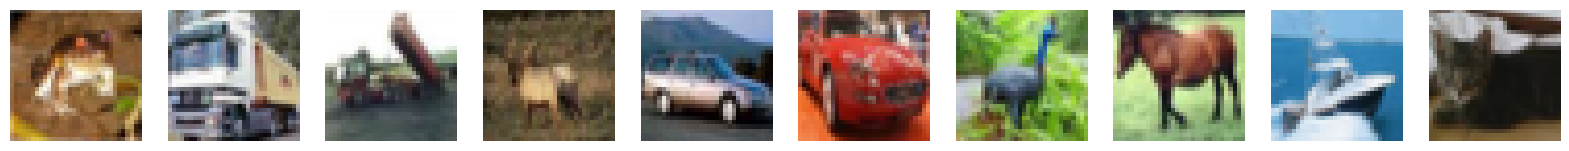

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [6]:
display(x_train[:10])
print(y_train[:10])

### Build the Model

The Conv2D layer applies convolution operation to an input tensor with two spatial dimentions.  

- The **strides** parameter is the step size that is used to move the filter across input 
- The **padding** specifies the strategy such the the reduced size of the output after convolution can be made exactly same as the input size 

In general, the shape of the output from a convolutional layer with same padding is (?, height/stride, width/stride, filters)

**Batch Normlization**  

One of the problem during trianing of model is the exploding gradient problem where the weights of the network starts to become to large. One of the reason is Covariate shift where once the activations distributions starts to shift toward certain direction, trying to stablizing it may not work in run iteration eventually collapsing the network. 

To solve this problem, during the training, the mean and standard deviation of each of the input channels across batch is calculated and the standard normaliztion is performed and it is scaled and shifted using gamma and beta variables which needs to be trained. 

**Dropouts**  

Dropout is regularization technique which is used to tackle the problem of overfitting by penalizing the model if it starts to overfit. Here, during the training time, output from the random set of units from the preceding layer is turned off. This results in avoiding the network to be overdependend on certain units and drastically reduces overfitting. 

In [15]:
input_layer = layers.Input((32,32,3))

x = layers.Conv2D(filters=32, kernel_size=3, strides=1,padding="same")(input_layer)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3 , strides=1,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3 , strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.5)(x)

x = layers.Dense(NUM_CLASSES)(x)
output_layer = layers.Activation("Softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                           

### Model Compilation 


In [10]:
opt = optimizers.Adam(learning_rate = 0.0005)
model.compile(
    loss="categorical_crossentropy", optimizer = opt , metrics = ["accuracy"]
)

### Train the model 

In [11]:
model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    shuffle=True,
    validation_data=(x_test, y_test),
)


Epoch 1/10


2023-07-10 05:57:25.016514: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-07-10 05:57:26.141391: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1563/1563 [==============================] - 8s 3ms/step - loss: 1.5629 - accuracy: 0.4494 - val_loss: 1.5583 - val_accuracy: 0.4675
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1646 - accuracy: 0.5872 - val_loss: 1.1117 - val_accuracy: 0.6093
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0075 - accuracy: 0.6481 - val_loss: 0.9881 - val_accuracy: 0.6533
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9250 - accuracy: 0.6785 - val_loss: 1.0144 - val_accuracy: 0.6425
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8560 - accuracy: 0.7015 - val_loss: 1.0184 - val_accuracy: 0.6536
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8042 - accuracy: 0.7209 - val_loss: 0.9057 - val_accuracy: 0.6851
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7633 - accuracy: 0.7333 - val_loss: 0.8394 - val_accuracy: 0.7080
Epo

### Evaluation 

In [12]:
model.evaluate(x_test, y_test, batch_size = 1000)

10/10 [==============================] - 0s 13ms/step - loss: 0.8156 - accuracy: 0.7277


[0.8156114816665649, 0.7276999950408936]

In [13]:
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

313/313 [==============================] - 0s 983us/step


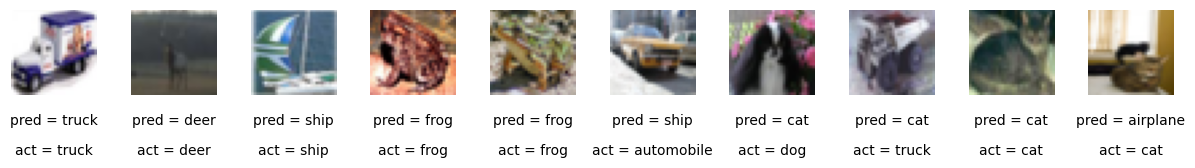

In [14]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)